# Demonstration notebook
The purpose of this notebook is to demonstrate two models: the classification ResNet50 and the U-Net with a ResNet50 encoder that work sequentially for ship detection

In [1]:
# Import libraries
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Set up GPU memory configuration
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

Segmentation Models: using `keras` framework.


#### Preparing Images

In [2]:
# Define global variables and hyperparameters
CHECKPOINT_PATH_SEGMENTATION_MODEL = r"models/unet_resnet50/unet_resnet50.ckpt"
CHECKPOINT_PATH_CLASSIFICATION_MODEL = r"models/resnet50classifier/resnet50classifier.ckpt"
PATH_TO_IMAGES = r"airbus/train_v2/"
PATH_TO_CSV_DATA = r"train_ship_segmentations_prepared.csv"
IMG_SHAPE = 256

In [3]:
# Create function for generating relative paths for images
def add_root(x, path=PATH_TO_IMAGES):
    """
    Args:
    - x: A string representing a relative path.
    - path: The root directory path to prepend (default is PATH_TO_IMAGES).

    Returns:
    - The combined filename and the provided relative path.
    """
    return path+x

In [4]:
# Read CSV metadata file
df = pd.read_csv(PATH_TO_CSV_DATA)

# Group by unique image names and preserve other columns' information
prepared_df = df.groupby('ImageId')[["ship_count", "ship_present"]].max().reset_index()

# Split images and labels into training, development, and testing sets
X_train, X_val = train_test_split(prepared_df, test_size=0.1, random_state=42, stratify=prepared_df["ship_count"])
X_dev, X_test = train_test_split(X_val, test_size=0.5, random_state=42, stratify=X_val["ship_count"])

# Apply function for generating relative paths for images
X_test["image_filepaths"] = X_test["ImageId"].apply(add_root, path=PATH_TO_IMAGES)

#### Load classification model based on ResNet50

In [5]:
# Define the input image shape
input_shape = (IMG_SHAPE, IMG_SHAPE, 3)

# Download and initialize the pre-trained classification model
base_model = tf.keras.applications.resnet.ResNet50(include_top=False)
base_model.trainable = False

# Create a ResNet50 model with a head for 2 classes
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = tf.keras.layers.Dense(1, activation='sigmoid', dtype=tf.float32)(x)
classification_model = tf.keras.Model(inputs, x)

# Load the classification model weights
classification_model.load_weights(CHECKPOINT_PATH_CLASSIFICATION_MODEL)

#### Load segmentation model based on ResNet50 encoder

In [6]:
# Download and initialize the pre-trained segmentation model
segmentation_model = Unet(backbone_name='resnet50', encoder_weights='imagenet', encoder_freeze=True)

# Load the segmentation model weights
segmentation_model.load_weights(CHECKPOINT_PATH_SEGMENTATION_MODEL)

In [7]:
# Define a colormap (from transparent to yellow) for masks
transparent_yellow = LinearSegmentedColormap.from_list("transparent_yellow", [(1, 1, 0, 0), (1, 1, 0, 1)], N=256)

#### Creating a function to demonstrate the model's performance on random images from the test set

In [8]:
# Create list with image filepaths
list_of_filepaths = X_test["image_filepaths"].to_list()

def plot_images_and_predicted_masks(list_of_filepaths=list_of_filepaths, seed=42, num=10):
    """
    Visualizes randomly selected images along with predicted masks (if a ship is found).

    Args:
    - list_of_filepaths (list): A list containing file paths to images.
    - seed (int): A seed value for randomization (default is 42).
    - num (int): Number of images to visualize (default is 10).

    Returns:
    - None

    Description:
    This function randomly selects 'num' images from 'list_of_filepaths', processes each image:
    - Reads the image file, resizes it, and uses a classification model to predict if it contains a ship.
    - If a ship is found, utilizes a segmentation model to predict a mask indicating the ship's location.
    - Displays the original image alongside the predicted mask (if applicable) indicating the ship's position.
    """
    random.seed(seed)
    random_image_paths = random.sample(list_of_filepaths, num)
    
    for i, random_image_path in enumerate(random_image_paths):
    
        img = tf.io.read_file(random_image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE])
    
        # Classification
        pred_prob_class = classification_model.predict(tf.expand_dims(img, 0), verbose=0)
        threshold_class = 0.5
        pred_class = int((pred_prob_class > threshold_class).astype("int32")[0])
    
        # Segmentation
        if pred_class == 1:
            ship_status = "Ship found"
            pred_prob_segm = segmentation_model.predict(tf.expand_dims(img, axis=0), verbose=0)
            threshold_segm = 0.5
            pred_segm = tf.cast(pred_prob_segm > threshold_segm, dtype=tf.float32)
        else:
            ship_status = "Ship not found"
            pred_segm = tf.zeros((1, IMG_SHAPE, IMG_SHAPE, 1), dtype=tf.float32)
    
        plt.figure(figsize=(8, 5)) 
    
        plt.suptitle(f"Pair-{i+1}: {ship_status}", fontsize=14)  
    
        plt.subplot(1, 2, 1)
        plt.imshow(img / 255.)
        plt.title("Image")
        plt.axis("off")
    
        plt.subplot(1, 2, 2)
        plt.imshow(img / 255.)
        plt.imshow(tf.squeeze(pred_segm, axis=0), cmap=transparent_yellow, alpha=0.5)
        
        plt.title("Predicted mask+image")
        plt.axis("off")
    
        plt.tight_layout()

#### Ship detection demonstration
You can rerun the cell below with different values of the "seed" parameter to create masks for random images from the test dataset. "num" is used to choose the number of images for display

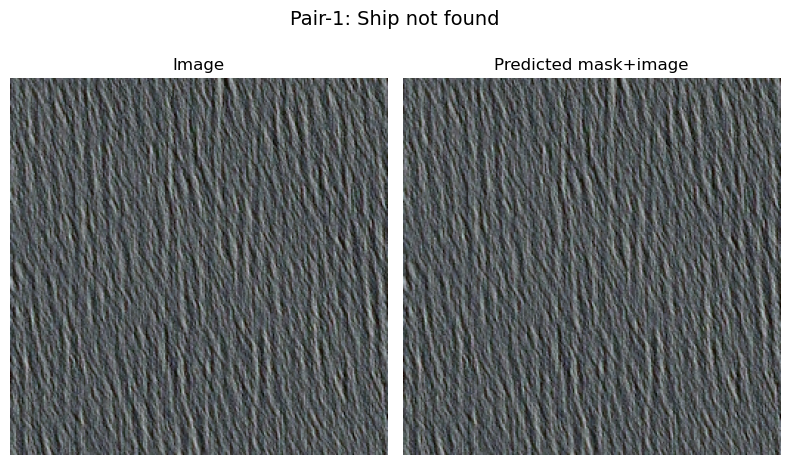

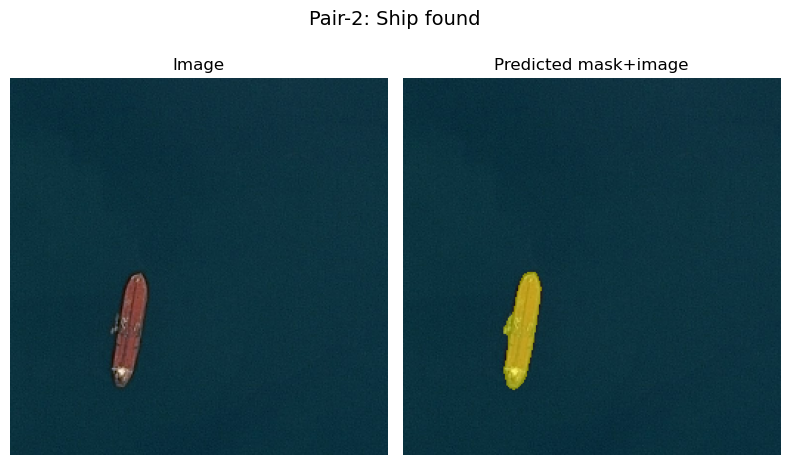

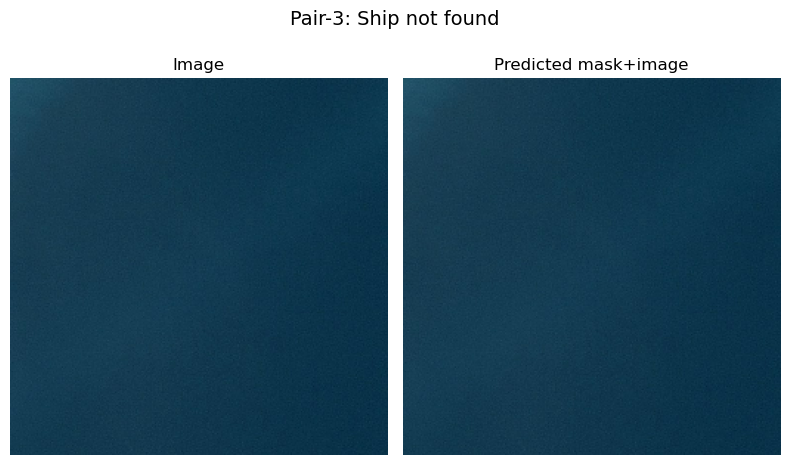

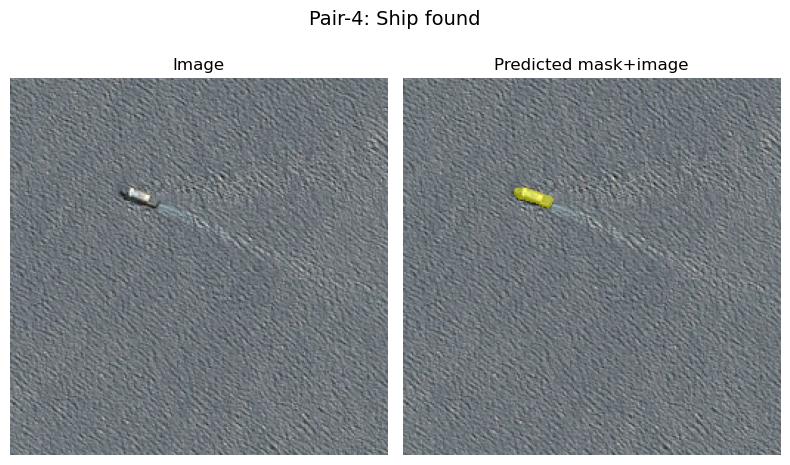

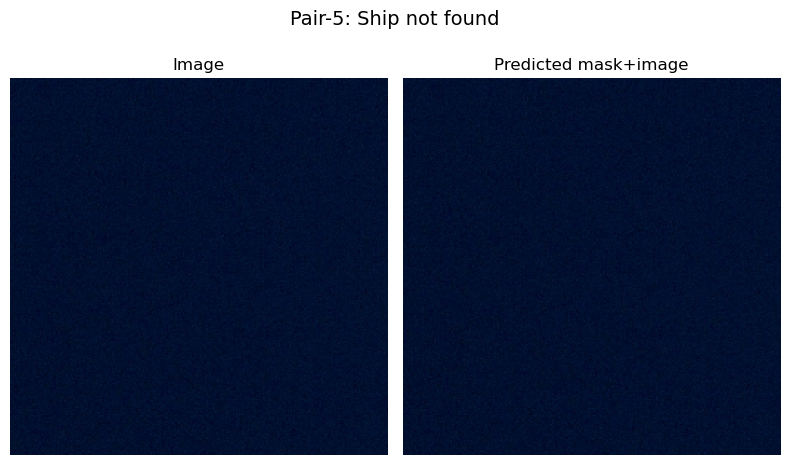

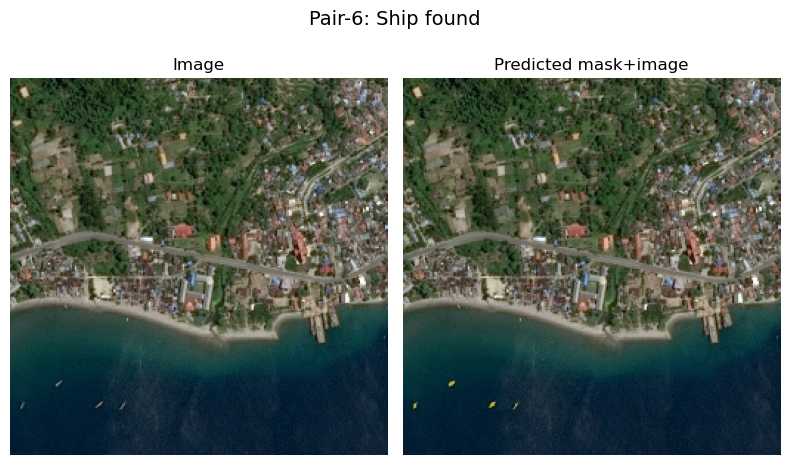

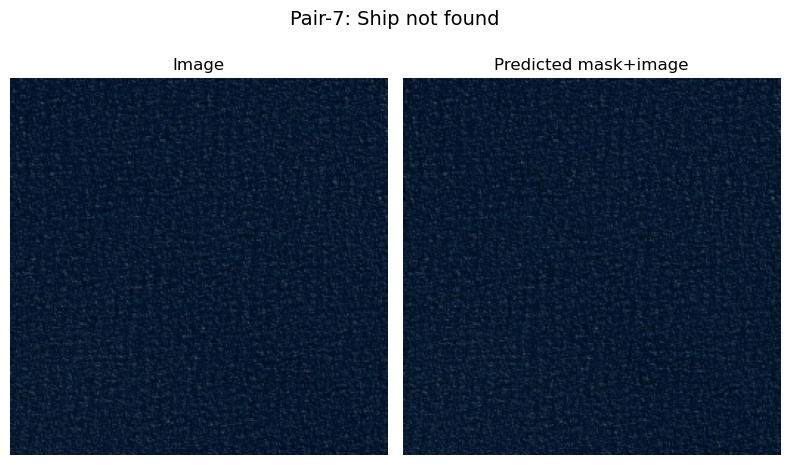

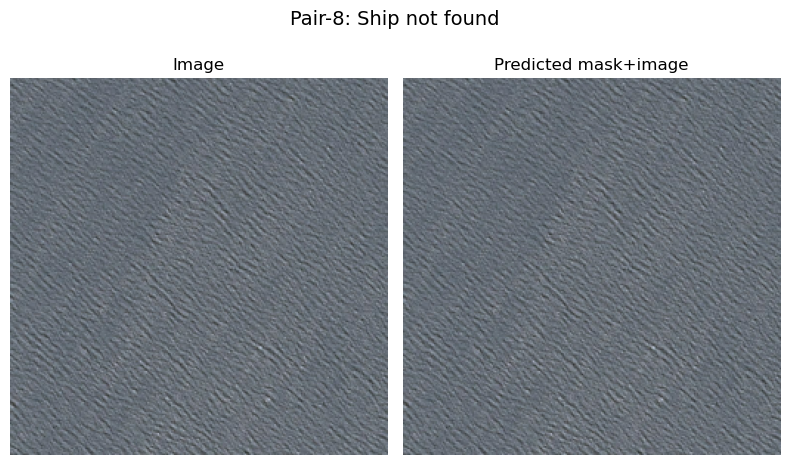

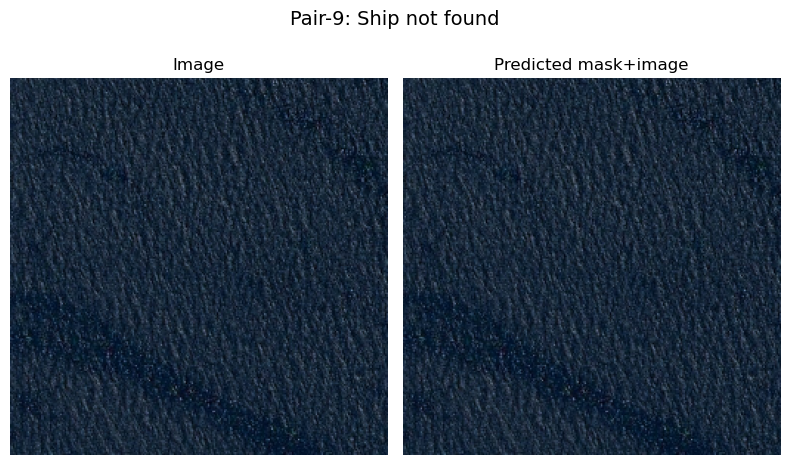

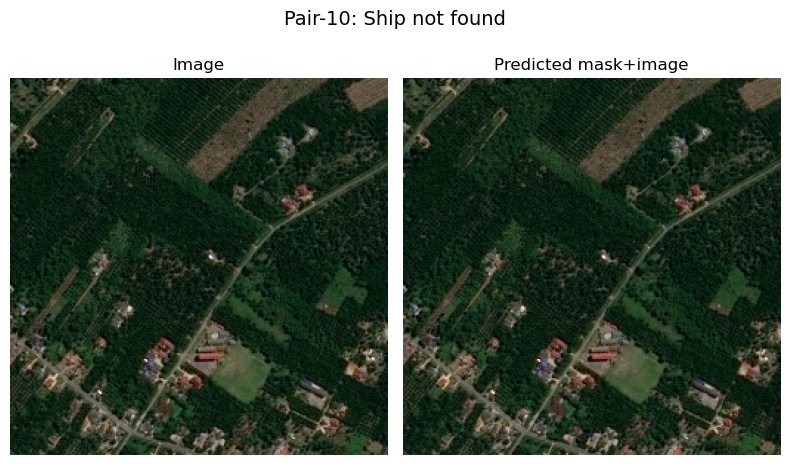

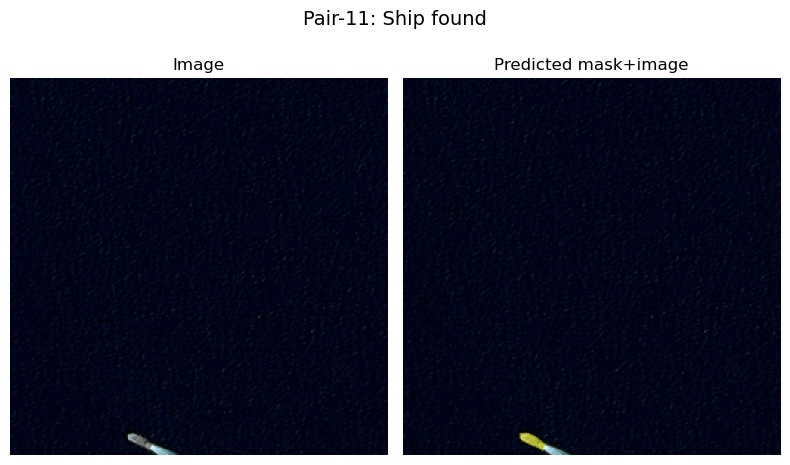

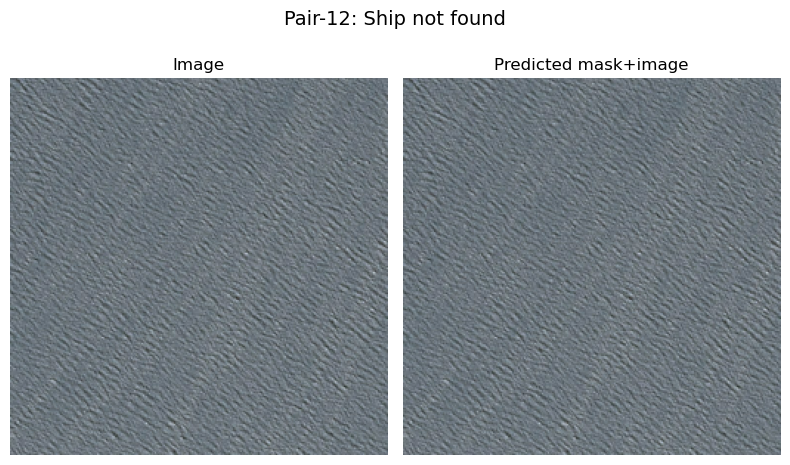

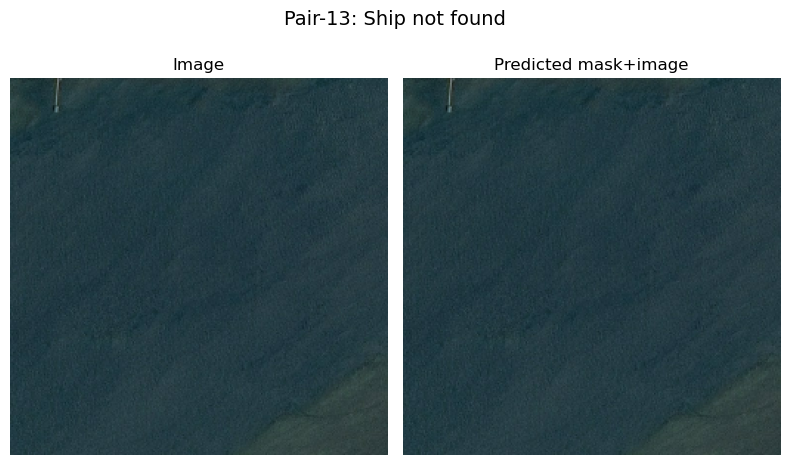

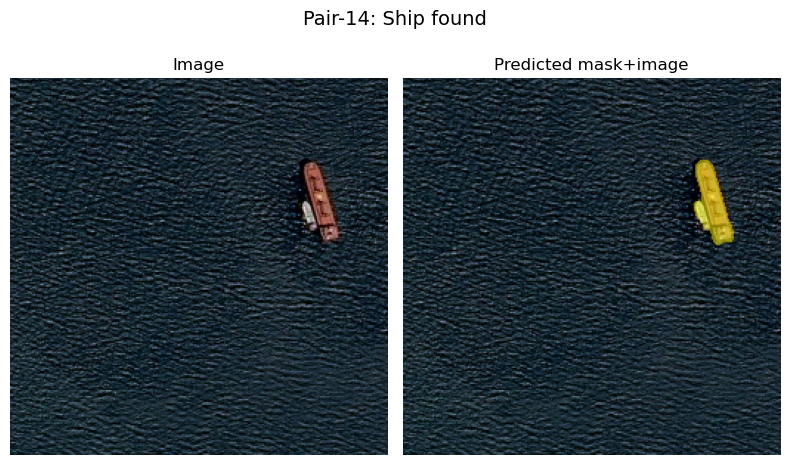

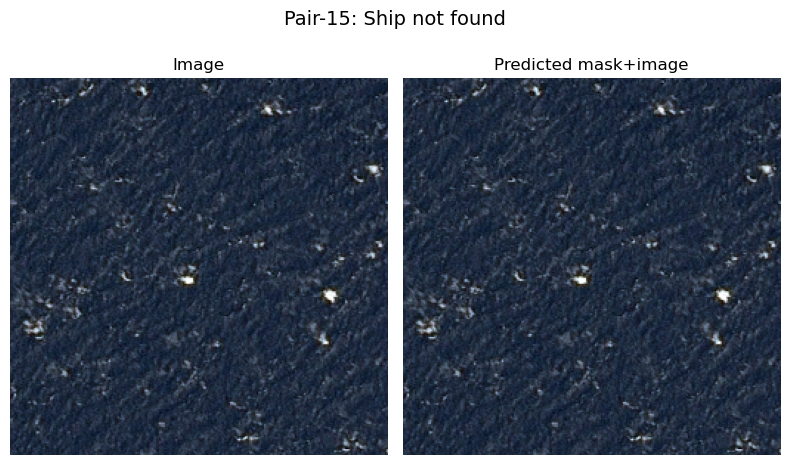

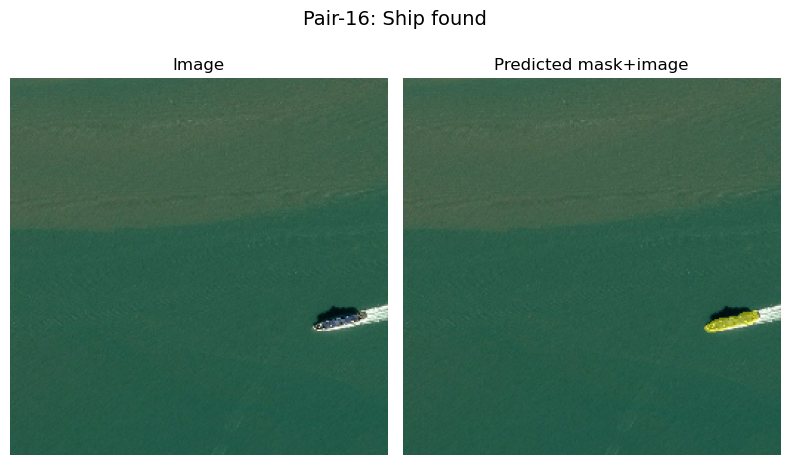

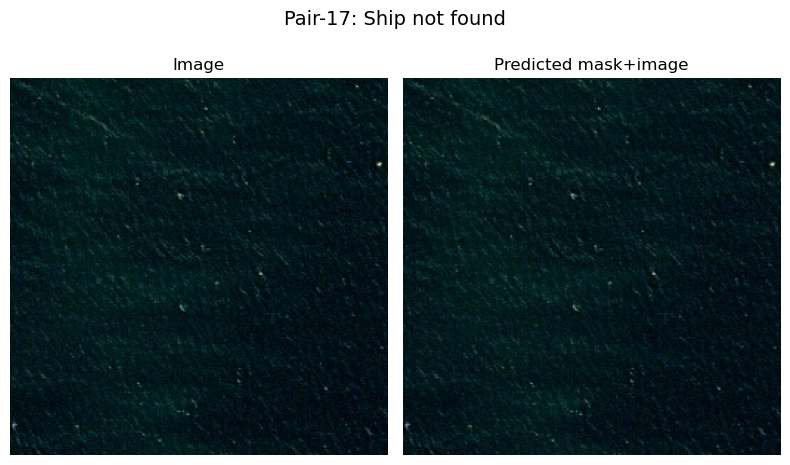

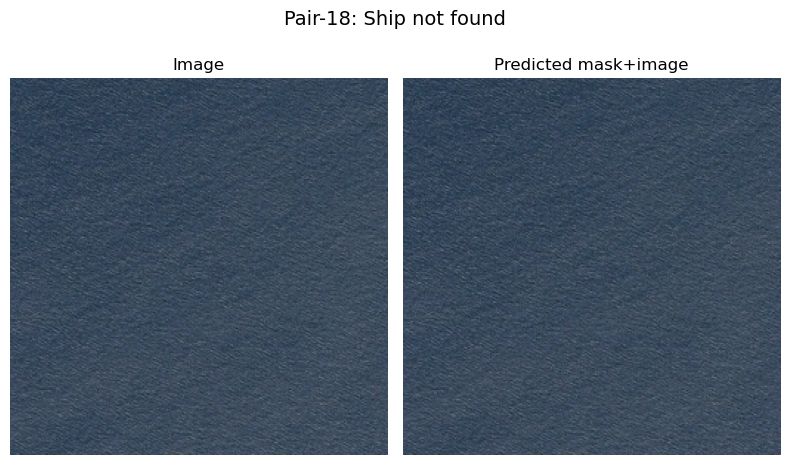

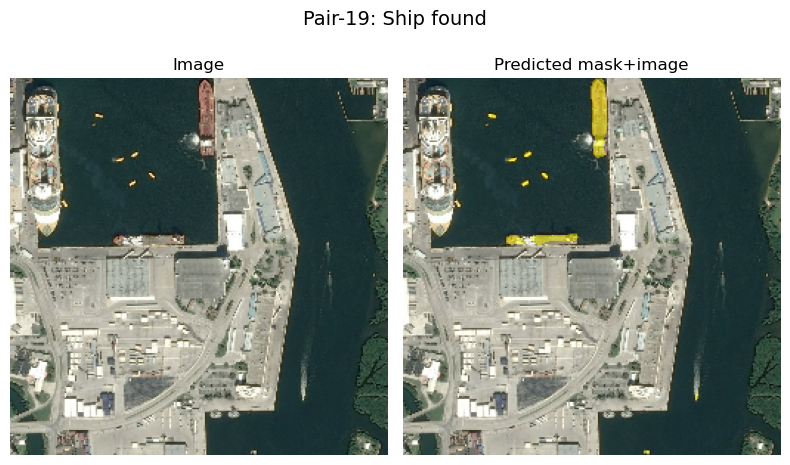

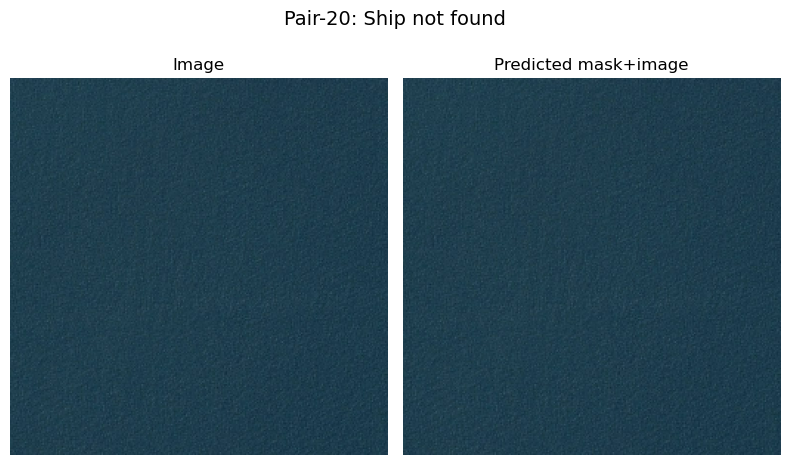

In [9]:
plot_images_and_predicted_masks(seed=42, num=20)